# IAM Context-Aware Behavioural Machine Learning Model
This code is presented in five sections:

Data Simulation: Creates the high-fidelity synthetic log file with 350,000 events and MITRE ATT&CK matrix-inspired attacks.

Feature Engineering: Loads the log file and creates our feature set.

Model Hyperparameter Tuning: Systematically runs the three tuning loops (contamination, n_estimators, max_samples) to find the optimal parameters and justify our choices.

Final Model Evaluation & Benchmarking: Trains model with the best parameters, calculates all final metrics (F1, ROC-AUC).

## Import Libraries
These are all the relevant libraries that are used in the code

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import ipaddress
import json
import ipaddress
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix
)

## Data Simulation

In [2]:
#configuration
random.seed(42)
np.random.seed(42)

### Simulation Timeframe

In [3]:
SIM_DAYS = 30
START_DATE = datetime(2025, 10, 1, 0, 0, 0)
END_DATE = START_DATE + timedelta(days=SIM_DAYS)

### Resource & Identity ARNs

In [4]:
ARN_DEV_JANE = 'arn:aws:iam::123456789012:user/devops-jane'
ARN_ANA_BOB = 'arn:aws:iam::123456789012:user/analyst-bob'
ARN_APP_ROLE = 'arn:aws:sts::123456789012:assumed-role/app-prod-role/i-012345abcdef'
ARN_ADMIN_POLICY = 'arn:aws:iam::aws:policy/AdministratorAccess'

### IPs and Networks

In [5]:
IP_CORP_NETWORK = '198.51.100.0/24'
IP_DEV_WFH = '15.20.25.30'
IP_APP_ROLE = '10.0.10.50'
IP_ATTACK_PRIVESC = '185.12.33.4'
IP_ATTACK_TRAVEL = '212.102.34.18'
IP_ATTACK_MANIPULATION = '198.18.0.5'

### Helper Functions

In [6]:
def generate_random_ip(network_str):
    network = ipaddress.ip_network(network_str)
    return str(network[random.randint(0, network.num_addresses - 1)])

def choose_weighted(choices_dict):
    choices = list(choices_dict.keys())
    weights = list(choices_dict.values())
    return random.choices(choices, weights=weights, k=1)[0]

def random_timestamp(start, end, work_hours=True, weekday_only=True):
    while True:
        delta = end - start
        random_seconds = random.randint(0, int(delta.total_seconds()))
        ts = start + timedelta(seconds=random_seconds)
        is_weekday = ts.weekday() < 5
        is_work_hour = 8 <= ts.hour <= 18
        if not weekday_only or is_weekday:
            if not work_hours or is_work_hour:
                return ts

def create_log_entry(timestamp, arn, utype, event, source, ip, agent, params, error, anomaly, mitre_tactic="Normal_Operation"):
    """Helper to create a single log entry."""
    return {
        'eventTime': timestamp.isoformat() + 'Z',
        'userIdentity.arn': arn,
        'userIdentity.type': utype,
        'eventName': event,
        'eventSource': source,
        'sourceIPAddress': ip,
        'userAgent': agent,
        'requestParameters': json.dumps(params) if params else None,
        'errorCode': error,
        'is_anomaly': anomaly,
    }

### Persona Simulation

In [7]:
def simulate_devops_jane(num_events):
    events = []
    ip_choices = {generate_random_ip(IP_CORP_NETWORK): 0.9, IP_DEV_WFH: 0.1}
    agent_choices = {'aws-cli/2.13.25': 0.7, 'Mozilla/5.0...Console': 0.2, 'Terraform/1.5.0': 0.1}
    event_choices = {
        'DescribeInstances': 0.2, 'ListBuckets': 0.15, 'GetLogEvents': 0.1, 
        'GetMetricData': 0.1, 'ListRoles': 0.05, 'RunInstances': 0.05, 
        'TerminateInstances': 0.05, 'PutObject': 0.1, 'AssumeRole': 0.1,
        'CreatePolicy': 0.01, 'AttachRolePolicy': 0.01, 'CreateSecurityGroup': 0.03
    }
    
    for _ in range(num_events):
        ts = random_timestamp(START_DATE, END_DATE, work_hours=True, weekday_only=True)
        event_name = choose_weighted(event_choices)
        source = event_name.split(':')[0].lower() + '.amazonaws.com'
        if event_name == 'ListBuckets': source = 's3.amazonaws.com'
        
        events.append(create_log_entry(
            timestamp=ts, arn=ARN_DEV_JANE, utype='IAMUser', event=event_name,
            source=source, ip=choose_weighted(ip_choices), agent=choose_weighted(agent_choices),
            params={'exampleParam': 'value'}, error=None, anomaly=0,
        ))
    return events

def simulate_analyst_bob(num_events):
    events = []
    ip_choices = {generate_random_ip(IP_CORP_NETWORK): 1.0}
    agent_choices = {'Mozilla/5.0...Console': 0.8, 'aws-sdk-python/1.2.3': 0.2}
    event_choices = {
        'StartQueryExecution': 0.3, 'GetQueryResults': 0.3, 'GetObject': 0.2,
        'GetTable': 0.1, 'GetDatabase': 0.05, 'ListBuckets': 0.05
    }
    for _ in range(num_events):
        ts = random_timestamp(START_DATE, END_DATE, work_hours=True, weekday_only=True)
        event_name = choose_weighted(event_choices)
        if 'Query' in event_name: source = 'athena.amazonaws.com'
        elif 'Get' in event_name: source = 'glue.amazonaws.com'
        else: source = 's3.amazonaws.com'     
        events.append(create_log_entry(
            timestamp=ts, arn=ARN_ANA_BOB, utype='IAMUser', event=event_name,
            source=source, ip=choose_weighted(ip_choices), agent=choose_weighted(agent_choices),
            params={'bucketName': 'analytics-data'}, error=None, anomaly=0
        ))
    return events

def simulate_app_role(num_events):
    events = []
    agent = 'aws-sdk-java/2.17.10'
    event_choices = { 'GetObject': 0.4, 'PutObject': 0.4, 'PutItem': 0.1, 'Query': 0.1 }
    for _ in range(num_events):
        ts = random_timestamp(START_DATE, END_DATE, work_hours=False, weekday_only=False)
        event_name = choose_weighted(event_choices)
        if 'Object' in event_name: source = 's3.amazonaws.com'
        else: source = 'dynamodb.amazonaws.com'
        events.append(create_log_entry(
            timestamp=ts, arn=ARN_APP_ROLE, utype='AssumedRole', event=event_name,
            source=source, ip=IP_APP_ROLE, agent=agent,
            params={'tableName': 'app-table'}, error=None, anomaly=0
        ))
    return events

### Anomaly Attack Injection

In [8]:
def inject_privilege_escalation(base_time):
    events = []
    events.append(create_log_entry(
        timestamp=base_time + timedelta(minutes=1), arn=ARN_DEV_JANE, utype='IAMUser',
        event='ListAttachedUserPolicies', source='iam.amazonaws.com', ip=IP_ATTACK_PRIVESC,
        agent='aws-cli/2.11.0', params={'userName': 'devops-jane'}, error=None, anomaly=1,
    ))
    events.append(create_log_entry(
        timestamp=base_time + timedelta(minutes=3), arn=ARN_DEV_JANE, utype='IAMUser',
        event='AttachUserPolicy', source='iam.amazonaws.com', ip=IP_ATTACK_PRIVESC,
        agent='aws-cli/2.11.0', params={'userName': 'devops-jane', 'policyArn': ARN_ADMIN_POLICY},
        error=None, anomaly=1
    ))
    return events

def inject_create_access_key(base_time):
    return [create_log_entry(
        timestamp=base_time, arn=ARN_DEV_JANE, utype='IAMUser', event='CreateAccessKey',
        source='iam.amazonaws.com', ip=IP_ATTACK_PRIVESC, agent='aws-cli/2.11.0',
        params={'userName': 'devops-jane'}, error=None, anomaly=1
    )]

def inject_account_manipulation(base_time):
    events = []
    tactic = "Account_Manipulation"
    events.append(create_log_entry(
        timestamp=base_time, arn=ARN_ANA_BOB, utype='IAMUser', event='UpdateLoginProfile',
        source='iam.amazonaws.com', ip=IP_ATTACK_MANIPULATION, agent='aws-cli/2.11.0',
        params={'userName': 'analyst-bob', 'password': '...'}, error='AccessDenied',
        anomaly=1
    ))
    events.append(create_log_entry(
        timestamp=base_time + timedelta(minutes=2), arn=ARN_ANA_BOB, utype='IAMUser',
        event='CreateVirtualMFADevice', source='iam.amazonaws.com', ip=IP_ATTACK_MANIPULATION,
        agent='aws-cli/2.11.0', params={'virtualDeviceName': 'bobs-mfa'}, error='AccessDenied',
        anomaly=1
    ))
    return events

def inject_impossible_travel(base_time):
    events = []
    events.append(create_log_entry(
        timestamp=base_time, arn=ARN_ANA_BOB, utype='IAMUser', event='ConsoleLogin',
        source='signin.amazonaws.com', ip=generate_random_ip(IP_CORP_NETWORK),
        agent='Mozilla/5.0...Console', params=None, error=None, anomaly=0
    ))
    events.append(create_log_entry(
        timestamp=base_time + timedelta(minutes=10), arn=ARN_ANA_BOB, utype='IAMUser',
        event='ListBuckets', source='s3.amazonaws.com', ip=IP_ATTACK_TRAVEL,
        agent='aws-cli/2.11.0', params=None, error=None, anomaly=1
    ))
    return events

### Main Simulation Execution

In [9]:
all_events = []
all_events.extend(simulate_devops_jane(num_events=100000))
all_events.extend(simulate_analyst_bob(num_events=80000))
all_events.extend(simulate_app_role(num_events=150000))

num_anomalies_to_inject = 8000
for _ in range(num_anomalies_to_inject):
    attack_time = random_timestamp(START_DATE, END_DATE, work_hours=False, weekday_only=False)
    attack_type = random.choice([1, 2, 3, 4])
    
    if attack_type == 1:
        all_events.extend(inject_privilege_escalation(attack_time))
    elif attack_type == 2:
        all_events.extend(inject_create_access_key(attack_time))
    elif attack_type == 3:
        all_events.extend(inject_account_manipulation(attack_time))
    else:
        all_events.extend(inject_impossible_travel(attack_time))

print(f"\nTotal events generated: {len(all_events)}")


Total events generated: 344034


### Clean up  and Save

In [10]:
df = pd.DataFrame(all_events)
df['errorCode'].fillna('Success', inplace=True)
df['requestParameters'].fillna('{}', inplace=True)
df['eventTime'] = pd.to_datetime(df['eventTime'])
df.sort_values(by='eventTime', inplace=True)
df.reset_index(drop=True, inplace=True)

output_file = 'iam_simulation.csv'
df.to_csv(output_file, index=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_13212\3291686567.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['errorCode'].fillna('Success', inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13212\3291686567.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

### Preview the Simulated Data

In [11]:
print("\n--- Dataset Head ---")
print(df.head())
print("\n--- Anomaly Distribution ---")
print(df['is_anomaly'].value_counts())
print("\n--- Anomaly Percentage ---")
print(df['is_anomaly'].value_counts(normalize=True))


--- Dataset Head ---
                  eventTime  \
0 2025-10-01 00:00:35+00:00   
1 2025-10-01 00:00:45+00:00   
2 2025-10-01 00:01:02+00:00   
3 2025-10-01 00:01:24+00:00   
4 2025-10-01 00:01:37+00:00   

                                    userIdentity.arn userIdentity.type  \
0  arn:aws:sts::123456789012:assumed-role/app-pro...       AssumedRole   
1  arn:aws:sts::123456789012:assumed-role/app-pro...       AssumedRole   
2  arn:aws:sts::123456789012:assumed-role/app-pro...       AssumedRole   
3  arn:aws:sts::123456789012:assumed-role/app-pro...       AssumedRole   
4  arn:aws:sts::123456789012:assumed-role/app-pro...       AssumedRole   

   eventName             eventSource sourceIPAddress             userAgent  \
0  PutObject        s3.amazonaws.com      10.0.10.50  aws-sdk-java/2.17.10   
1  GetObject        s3.amazonaws.com      10.0.10.50  aws-sdk-java/2.17.10   
2  PutObject        s3.amazonaws.com      10.0.10.50  aws-sdk-java/2.17.10   
3      Query  dynamodb.amazonaws.c

## Feature Engineering

In [12]:
try:
    df = pd.read_csv('iam_simulation.csv')
except FileNotFoundError:
    print("Error: 'iam_simulation.csv' not found.")
    raise

df['eventTime'] = pd.to_datetime(df['eventTime'])
df = df.sort_values(by='eventTime').reset_index(drop=True)

# This will be our new feature DataFrame
X = pd.DataFrame()

X['hour_of_day'] = df['eventTime'].dt.hour
X['day_of_week'] = df['eventTime'].dt.weekday

# Rarity Features
X['eventName_rarity_by_user'] = (
    df.groupby('userIdentity.arn')['eventName']
    .transform(lambda x: x.map(x.value_counts(normalize=True)))
)
X['ip_rarity_by_user'] = (
    df.groupby('userIdentity.arn')['sourceIPAddress']
    .transform(lambda x: x.map(x.value_counts(normalize=True)))
)

# --- contextual_risk_score ---
# Component 1: Is it an error?
component_1_error = (df['errorCode'] != 'Success').astype(int)

# Component 2: Is it at an odd hour?
component_2_odd_hour = ((X['hour_of_day'] < 8) | (X['hour_of_day'] > 18)).astype(int)

# Component 3: Is it on a weekend?
component_3_weekend = (X['day_of_week'] > 4).astype(int) # 5=Sat, 6=Sun

# Component 4: Is the IP untrusted?
TRUSTED_NETWORKS = [
    ipaddress.ip_network('198.51.100.0/24'), # IP_CORP_NETWORK
    ipaddress.ip_network('15.20.25.30/32'),   # IP_DEV_WFH
    ipaddress.ip_network('10.0.10.50/32')    # IP_APP_ROLE
]
def check_ip_trusted(ip_str):
    if not ip_str or not isinstance(ip_str, str): return False
    try:
        ip = ipaddress.ip_address(ip_str)
        for network in TRUSTED_NETWORKS:
            if ip in network: return True
        return False
    except ValueError:
        return False
# 1 if untrusted, 0 if trusted
component_4_untrusted_ip = (df['sourceIPAddress'].apply(check_ip_trusted) == False).astype(int)

# Component 5: Is the User Agent new for this user?
component_5_new_agent = (
    df.groupby(['userIdentity.arn', 'userAgent'])
    .cumcount() == 0
).astype(int)

# Sum all components to create the final score
X['contextual_risk_score'] = (
    component_1_error + 
    component_2_odd_hour + 
    component_3_weekend + 
    component_4_untrusted_ip + 
    component_5_new_agent
)

# --- Final Label Encoding ---
print("Finalizing and encoding...")
categorical_cols = [
    'userIdentity.arn', 'userIdentity.type', 'eventName', 
    'eventSource', 'sourceIPAddress', 'userAgent', 'errorCode'
]
for col in categorical_cols:
    le = LabelEncoder()
    X[col + '_encoded'] = le.fit_transform(df[col].astype(str))

X = X.fillna(0) # Fill NaNs from rarity calcs

# --- Final Output ---
X_processed = X
y_true = df['is_anomaly']

print(f"feature set shape: {X_processed.shape}")
print("\n--- Features ---")
print(X_processed.columns.tolist())

Finalizing and encoding...
feature set shape: (344034, 12)

--- Features ---
['hour_of_day', 'day_of_week', 'eventName_rarity_by_user', 'ip_rarity_by_user', 'contextual_risk_score', 'userIdentity.arn_encoded', 'userIdentity.type_encoded', 'eventName_encoded', 'eventSource_encoded', 'sourceIPAddress_encoded', 'userAgent_encoded', 'errorCode_encoded']


### Splitting the Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y_true,
    test_size=0.3,
    random_state=42,
    stratify=y_true
)

### Initialize the model

In [14]:
model = IsolationForest(
    n_estimators=100,
    contamination='auto',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train)

IsolationForest(n_jobs=-1, random_state=42)

### Model Evaluation

In [15]:
predictions = model.predict(X_test)
y_pred = [1 if p == -1 else 0 for p in predictions]


precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

roc_auc = roc_auc_score(y_test, -model.decision_function(X_test))

print("\n=== Evaluation ===")
print("Precision: {:.4f}".format(precision))
print("Recall:    {:.4f}".format(recall))
print("F1-score:  {:.4f}".format(f1))
print("ROC-AUC:   {:.4f}".format(roc_auc))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Evaluation ===
Precision: 0.0667
Recall:    1.0000
F1-score:  0.1251
ROC-AUC:   0.9951

Confusion Matrix:
 [[49353 50263]
 [    0  3595]]


### Hyperparameter Tuning


--- Tuning Results (Contamination) ---
               precision    recall  f1_score
contamination                               
0.01            0.890656  0.248751  0.388889
0.02            0.788862  0.452249  0.574907
0.03            0.797210  0.682121  0.735189
0.04            0.747487  0.867018  0.802828
0.05            0.647778  0.926707  0.762536
0.06            0.564045  0.975569  0.714809
0.07            0.486383  0.991671  0.652659
0.08            0.430604  1.000000  0.601989
0.09            0.382703  1.000000  0.553558
0.10            0.344755  1.000000  0.512740


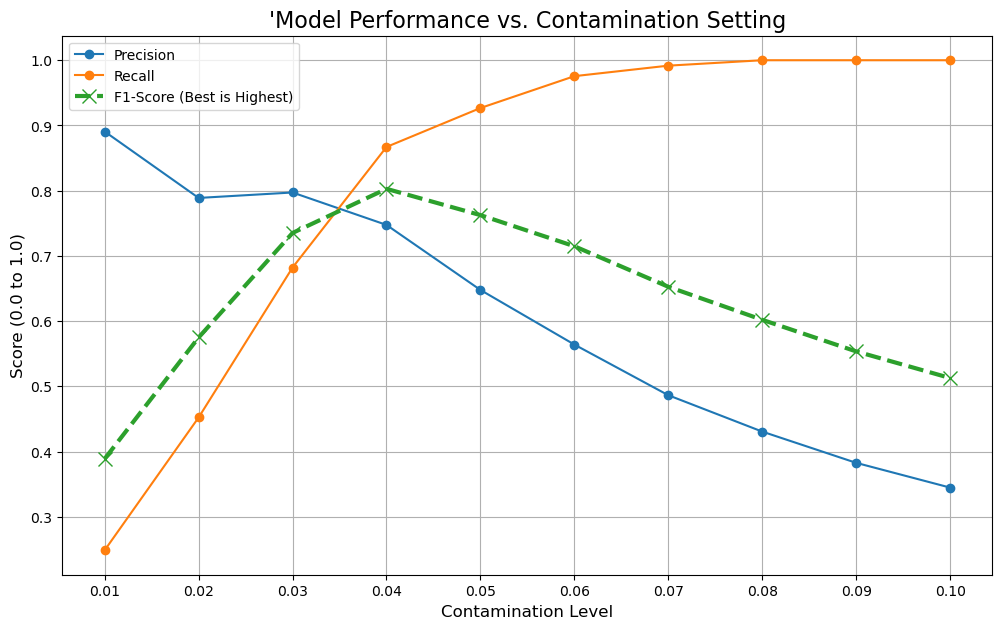

In [59]:
# Contamination Tuning Loop
contamination_levels = np.arange(0.01, 0.11, 0.01)
results = []

for cont_level in contamination_levels:
    level_str = f"{cont_level:.2f}"
    
    model = IsolationForest(
        n_estimators=100,
        contamination=cont_level,
        random_state=42,
        n_jobs=-1 # Use all available CPU cores
    )
    model.fit(X_train)
    
    predictions = model.predict(X_test)
    y_pred = [1 if p == -1 else 0 for p in predictions]
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'contamination': level_str,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Display Results
results_df = pd.DataFrame(results)
results_df = results_df.set_index('contamination')

print("\n--- Tuning Results (Contamination) ---")
print(results_df)

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(results_df.index, results_df['precision'], marker='o', label='Precision')
plt.plot(results_df.index, results_df['recall'], marker='o', label='Recall')
plt.plot(results_df.index, results_df['f1_score'], marker='x', linestyle='--', 
         linewidth=3, markersize=10, label='F1-Score (Best is Highest)')

plt.title("'Model Performance vs. Contamination Setting", fontsize=16)
plt.xlabel('Contamination Level', fontsize=12)
plt.ylabel('Score (0.0 to 1.0)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("Figure_1.png", dpi=300, bbox_inches='tight')
plt.show()


Tuning complete.

--- Tuning Results (n_estimators) ---
              precision    recall  f1_score
n_estimators                               
10             0.759233  0.880668  0.815454
20             0.776515  0.912378  0.838982
30             0.721064  0.836996  0.774717
40             0.704011  0.825035  0.759734
50             0.744458  0.868707  0.801797
100            0.750474  0.880111  0.810140
200            0.735996  0.866203  0.795809
300            0.739264  0.871488  0.799949
500            0.723117  0.849235  0.781118


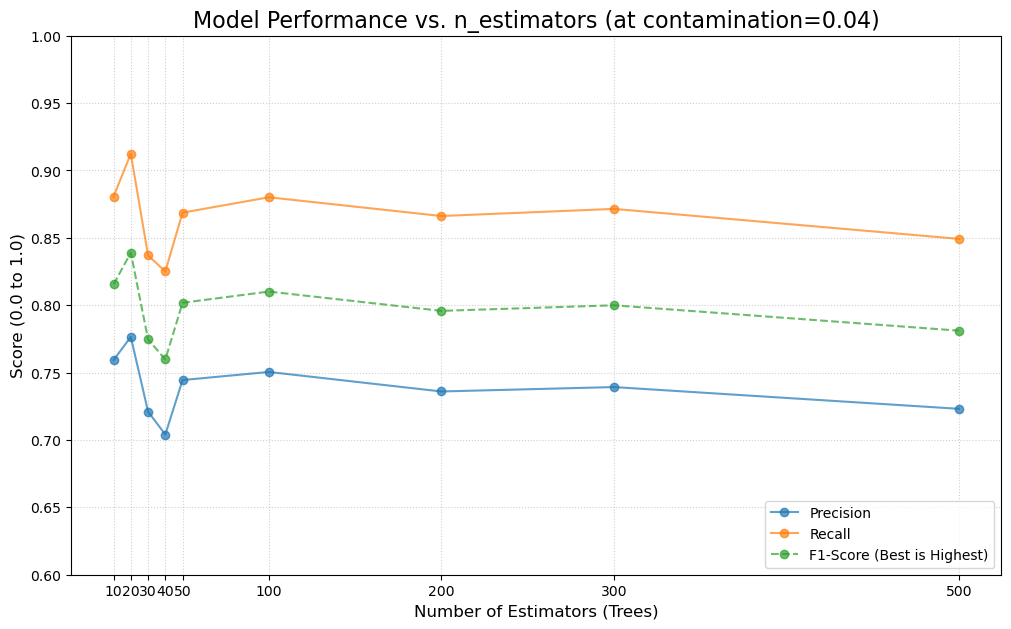

In [20]:
# Define Locked-in Parameter and Range to Test 
LOCKED_CONTAMINATION = 0.04
estimator_levels = [10, 20, 30, 40, 50, 100, 200, 300, 500]

results = []

# Run Tuning Loop
for n_est in estimator_levels:
       
    # Initialize the model with new settings
    model = IsolationForest(
        n_estimators=n_est,          
        contamination=LOCKED_CONTAMINATION,
        random_state=42,
        n_jobs=-1 
    )
    
    # Train on the training data
    model.fit(X_train)
    
    # Make predictions on the test data
    predictions = model.predict(X_test)
    y_pred = [1 if p == -1 else 0 for p in predictions]
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'n_estimators': n_est,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

print("\nTuning complete.")

# Display Results
results_df = pd.DataFrame(results)
results_df = results_df.set_index('n_estimators')

print("\n--- Tuning Results (n_estimators) ---")
print(results_df)

# Plot the results
plt.figure(figsize=(12, 7))


plt.plot(results_df.index, results_df['precision'], marker='o', label='Precision', alpha=0.7)
plt.plot(results_df.index, results_df['recall'], marker='o', label='Recall', alpha=0.7)
plt.plot(results_df.index, results_df['f1_score'], marker='o', linestyle='--', label='F1-Score (Best is Highest)', alpha=0.7)

plt.xticks(results_df.index) 
plt.ylim(0.6, 1.0)
# 4. Formatting
plt.title("Model Performance vs. n_estimators (at contamination=0.04)", fontsize=16)
plt.xlabel('Number of Estimators (Trees)', fontsize=12)
plt.ylabel('Score (0.0 to 1.0)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.6)

# 5. Save and Show
plt.savefig("Figure_2_Updated.png", dpi=300, bbox_inches='tight')
plt.show()


Tuning complete.

--- Tuning Results (max_samples) ---
             precision    recall  f1_score
max_samples                               
128           0.715358  0.848679  0.776336
256           0.776515  0.912378  0.838982
1024          0.577846  0.683449  0.626227
2048          0.579524  0.691238  0.630471
4096          0.539048  0.629764  0.580885
8192          0.461754  0.550765  0.502347


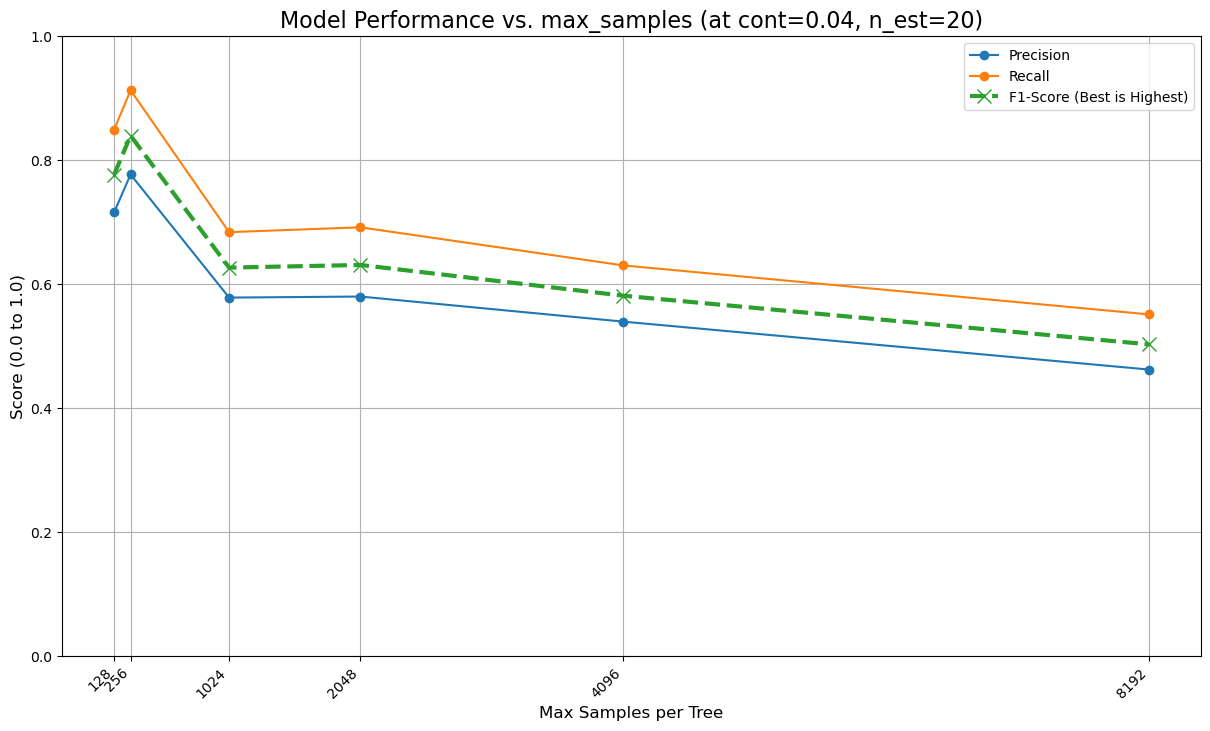

In [23]:
# Define Locked-in Parameters and Range to Test
LOCKED_CONTAMINATION = 0.04
LOCKED_N_ESTIMATORS = 20  # <-- Our new best value
sample_levels = [128, 256, 1024, 2048, 4096, 8192]

results = []

# Run Tuning Loop
for m_samples in sample_levels:
    # Initialize the model with new settings
    model = IsolationForest(
        n_estimators=LOCKED_N_ESTIMATORS,   
        contamination=LOCKED_CONTAMINATION, 
        max_samples=m_samples,              
        random_state=42,
        n_jobs=-1 
    )
    
    # Train on the training data
    model.fit(X_train)
    
    # Make predictions on the test data
    predictions = model.predict(X_test)
    y_pred = [1 if p == -1 else 0 for p in predictions]
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'max_samples': m_samples,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

print("\nTuning complete.")

# --- 3. Display Results ---
results_df = pd.DataFrame(results)
results_df = results_df.set_index('max_samples')

print("\n--- Tuning Results (max_samples) ---")
print(results_df)

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(results_df.index, results_df['precision'], marker='o', label='Precision')
plt.plot(results_df.index, results_df['recall'], marker='o', label='Recall')
plt.plot(results_df.index, results_df['f1_score'], marker='x', linestyle='--', 
         linewidth=3, markersize=10, label='F1-Score (Best is Highest)')
#Y-AXIS ADJUSTMENT: Zoomed in to see the delta
plt.ylim(0.0, 1.0) 

# 4. X-AXIS ADJUSTMENT: Force labels for your specific samples (e.g., 64, 128, 256, 512)
plt.xticks(results_df.index, rotation=45, ha='right') 

plt.tight_layout()
plt.savefig("max_samples_optimized_zoom.png", dpi=300)
plt.title("Model Performance vs. max_samples (at cont=0.04, n_est=20)", fontsize=16)
plt.xlabel('Max Samples per Tree', fontsize=12)
plt.ylabel('Score (0.0 to 1.0)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("Figure_3.png", dpi=300, bbox_inches='tight')
plt.show()

### Finalise the Model parameters.


   FINAL MODEL: ISOLATION FOREST
Parameters: {'n_estimators': 20, 'contamination': 0.04, 'max_samples': 256, 'random_state': 42, 'n_jobs': -1}

--- Key Metrics ---
Precision: 0.7765
Recall:    0.9124
F1-Score:  0.8390
ROC-AUC:   0.9951

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       1.00      0.99      0.99     99616
 Anomaly (1)       0.78      0.91      0.84      3595

    accuracy                           0.99    103211
   macro avg       0.89      0.95      0.92    103211
weighted avg       0.99      0.99      0.99    103211


--- Confusion Matrix ---
[[98672   944]
 [  315  3280]]


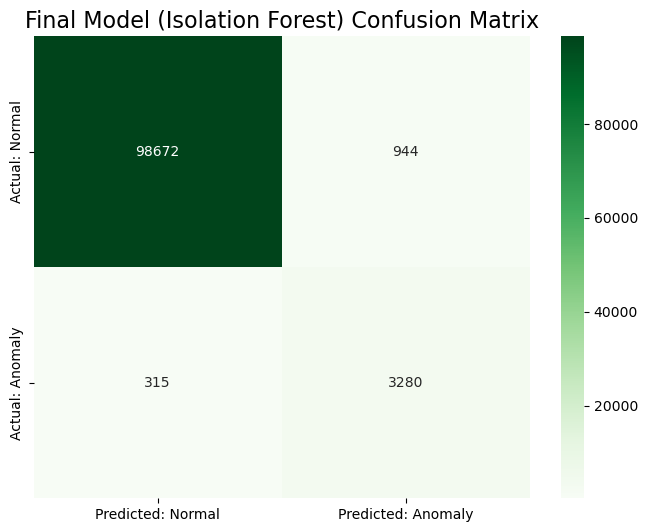

In [24]:
BEST_PARAMS = {
    'n_estimators': 20,
    'contamination': 0.04,
    'max_samples': 256,
    'random_state': 42,
    'n_jobs': -1
}

# Initialize and train the final model
final_model = IsolationForest(**BEST_PARAMS)
final_model.fit(X_train)

# --- Get predictions and scores ---
predictions_if = final_model.predict(X_test)
y_pred_if = [1 if p == -1 else 0 for p in predictions_if]
scores_if = -final_model.decision_function(X_test) # Flipped for ROC-AUC

# Full Evaluation
print("\n" + "="*40)
print("   FINAL MODEL: ISOLATION FOREST")
print("="*40)
print(f"Parameters: {BEST_PARAMS}")
print("\n--- Key Metrics ---")
print(f"Precision: {precision_score(y_test, y_pred_if):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_if):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_if):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, scores_if):.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_if, target_names=['Normal (0)', 'Anomaly (1)']))

print("\n--- Confusion Matrix ---")
cm_if = confusion_matrix(y_test, y_pred_if)
print(cm_if)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_if, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted: Normal', 'Predicted: Anomaly'],
            yticklabels=['Actual: Normal', 'Actual: Anomaly'])
plt.title('Final Model (Isolation Forest) Confusion Matrix', fontsize=16)
plt.show()

In [56]:
# FINAL ERROR ANALYSIS (for Discussion)

df_raw = pd.read_csv('iam_simulation.csv')
test_set_logs = df_raw.loc[y_test.index].copy()

# Add best model's predictions
y_pred_series = pd.Series(y_pred_if, index=y_test.index, name='y_pred')
analysis_df = test_set_logs
analysis_df['y_pred'] = y_pred_series
analysis_df.rename(columns={'is_anomaly': 'y_true'}, inplace=True)

# Isolate the remaining errors
false_negatives = analysis_df[
    (analysis_df['y_pred'] == 0) & (analysis_df['y_true'] == 1)
]
false_positives = analysis_df[
    (analysis_df['y_pred'] == 1) & (analysis_df['y_true'] == 0)
]

print(f"\nTotal Missed Attacks (False Negatives): {len(false_negatives)}")
if len(false_negatives) > 0:
    print("Missed Attack Events:")
    print(false_negatives['eventName'].value_counts())

print(f"\nTotal False Alarms (False Positives): {len(false_positives)}")
if len(false_positives) > 0:
    print("Normal Events Flagged as Attacks:")
    print(false_positives['eventName'].value_counts().head(10))


Total Missed Attacks (False Negatives): 422
Missed Attack Events:
eventName
ListAttachedUserPolicies    160
CreateAccessKey             137
AttachUserPolicy             89
ListBuckets                  14
UpdateLoginProfile           13
CreateVirtualMFADevice        9
Name: count, dtype: int64

Total False Alarms (False Positives): 1013
Normal Events Flagged as Attacks:
eventName
ConsoleLogin          584
Query                 123
AssumeRole             63
TerminateInstances     56
PutItem                47
AttachRolePolicy       36
GetObject              25
PutObject              20
CreatePolicy           14
DescribeInstances      12
Name: count, dtype: int64
